In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from copy import copy

warnings.filterwarnings('ignore')

# Reading Data

In [74]:
loanDf = pd.read_csv('loan.csv')
loanDf.shape

(39717, 111)

In [75]:
loanDf.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# Data Cleaning

## Handling missing values

### Dropping columns with significant amount of missing values

Getting a snapshot of the missing values for each columns, we see that there are many columns where every record is missing <br>
For example, **tot_hi_cred_lim, bc_mutil, bc_open_to_buy, avg_cur_bal, total_bc_limit, total_il_high_credit_limit, etc.** <br><br>
So we will simply drop these columns as there is no way to even impute their values

In [76]:
loanDf.isnull().sum().sort_values(ascending=False)

total_il_high_credit_limit    39717
mo_sin_old_rev_tl_op          39717
bc_util                       39717
bc_open_to_buy                39717
avg_cur_bal                   39717
                              ...  
pub_rec                           0
open_acc                          0
inq_last_6mths                    0
earliest_cr_line                  0
id                                0
Length: 111, dtype: int64

In [77]:
numRecords = loanDf.shape[0]
columnsWithAllNullValues = loanDf.loc[:, loanDf.isnull().sum() == numRecords].columns
len(columnsWithAllNullValues)

54

There are **54 columns where every entry in the row is NaN**. Let's drop these columns

In [78]:
loanDfWithDroppedColumns = loanDf.loc[:, loanDf.isnull().sum() != numRecords]
coloumnsDropped = list(columnsWithAllNullValues)

In [79]:
loanDfWithDroppedColumns.loc[:, loanDfWithDroppedColumns.isnull().sum() > 0.3*numRecords].isnull().sum().sort_values(ascending=False)

next_pymnt_d              38577
mths_since_last_record    36931
mths_since_last_delinq    25682
desc                      12940
dtype: int64

We see that there are still many columns which have significant amount of null values (30%). We will try to examine what they represent.

**next_pymnt_d** <br>
- The next scheduled payment date <br>
- **97% missing values** <br>
- These NaNs might be a technical error <br>
- We will **drop this column**. <br>

**mths_since_last_record** <br>
- Months since last public record. <br>
- **93% missing values** <br>
- These NaNs might be due to public records not being updated <br>
- We will **drop this column**. <br>

**mths_since_last_delinq** <br>
- Months since last delinquency <br>
- **65% missing values** <br>
- These NaNs might be because of no delinquency. This can be a prominent factor in determining the current financial state of the customer. No deliquency or greater the time-period since delinquency the better the financial state. <br>
- We will **drop this column** because we don't know the exact reason for the missing values and we don't want any bias in our data-set <br>

**desc** <br>
- Description provided by customer <br>
- **33% missing values** <br>
- These NaNs might be because no description was provided by customer. We cant really rely on this as there is no authenticity to the description that the customer provides. <br>
- We will **drop this column** as other complementary data is needed to make sense out of the information. <br>

In [80]:
cols = ['next_pymnt_d', 'mths_since_last_record', 'mths_since_last_delinq', 'desc'];
loanDfWithDroppedColumns.drop(columns=cols, inplace=True)
coloumnsDropped = coloumnsDropped + cols

Dropping a few more columns as they don't really contribute to the analysis.<br>
**emp_title** - Doesn't have anything to do with defaults <br>
**title** - Has many meaningless things written by customers and is covered within a broader field **purpose** <br>
**tax_liens** - Every value is either 0 or NaN <br>
**collections_12_mths_ex_med** - Every value is either 0 or NaN <br>
**chargeoff_within_12_mths** - Every value is either 0 or NaN <br>
**pymnt_plan** - Every value is 'n' <br>
**url** - Doesn't really matter to the analysis <br>
**initial_list_status** - Every value is 'f' <br>
**policy_code** - Every value is 1 <br>
**acc_now_delinq** - Every value is 0 <br>
**delinq_amnt** - Every value is 0 <br>
**id** - Doesn't matter to analysis <br>
**member_id** - Doesn't matter to analysis <br>

In [81]:
cols = ['emp_title', 'title', 'tax_liens', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
        'pymnt_plan', 'url', 'initial_list_status', 'policy_code', 'acc_now_delinq', 'delinq_amnt',
        'id', 'member_id'];
loanDfWithDroppedColumns.drop(columns=cols, inplace=True)
coloumnsDropped = coloumnsDropped + cols

**NOTE:** A very important thing to notice is that the information related to Customer behaviour variables will not be available when the customer applies for the loan. This information will start gettting recorded depending to the customer behaviour after he has recieved the loan. However, we need to make our risk analysis when the customer applies for the loan. So, it is advised to not make use of these Customer behavious variables in predicting defaults as ideally they won't be available at the time of assesment.

In [82]:
behaviouralVariables = ['last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line',
                        'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee',  
                        'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt']
loanDfWithDroppedColumns.drop(columns=behaviouralVariables, inplace=True)
coloumnsDropped = coloumnsDropped + behaviouralVariables

In [83]:
loanDfWithDroppedColumns.isnull().sum().sort_values(ascending=False)

emp_length              1075
pub_rec_bankruptcies     697
revol_util                50
purpose                    0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
zip_code                   0
application_type           0
addr_state                 0
dti                        0
delinq_2yrs                0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
loan_amnt                  0
dtype: int64

### Dropping records which have missing values

In [84]:
cols = ['emp_length', 'pub_rec_bankruptcies', 'revol_util']
dfWithCols = loanDfWithDroppedColumns.loc[:, cols]
loanDfWithDroppedColumns.loc[dfWithCols.isnull().sum(axis=1) > 0, :].shape

(1819, 31)

There are 1882 records that have missing values in either of the below columns: <br>
**'emp_length', 'pub_rec_bankruptcies', 'last_pymnt_d', 'revol_util', 'last_credit_pull_d'** <br> <br>
As the number of such records is not that significant (5%) we will remove these records

In [85]:
loanDfWithoutMissingValues = loanDfWithDroppedColumns.loc[dfWithCols.isnull().sum(axis=1) == 0, :]
loanDfWithoutMissingValues

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,application_type,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0,13648,83.70%,9,0.00,0.00,5863.155187,5833.84,INDIVIDUAL,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0,1687,9.40%,4,0.00,0.00,1008.710000,1008.71,INDIVIDUAL,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0,2956,98.50%,10,0.00,0.00,3005.666844,3005.67,INDIVIDUAL,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0,5598,21%,37,0.00,0.00,12231.890000,12231.89,INDIVIDUAL,0.0
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0,27783,53.90%,38,524.06,524.06,3513.330000,3513.33,INDIVIDUAL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39562,4800,4800,1100.0,36 months,10.28%,155.52,C,C1,1 year,RENT,...,1,5836,68.70%,12,0.00,0.00,5134.085288,1176.56,INDIVIDUAL,1.0
39573,7000,7000,1000.0,36 months,10.59%,227.82,C,C2,3 years,MORTGAGE,...,1,14930,79%,21,0.00,0.00,8174.021910,1167.72,INDIVIDUAL,1.0
39623,9000,9000,700.0,36 months,12.49%,301.04,D,D3,8 years,MORTGAGE,...,1,26233,62.90%,37,0.00,0.00,4015.960000,311.64,INDIVIDUAL,1.0
39666,15450,15450,600.0,36 months,11.22%,507.46,C,C4,2 years,MORTGAGE,...,1,6513,34.30%,29,0.00,0.00,11652.750000,451.73,INDIVIDUAL,1.0


### Dropping records whose loan is currently on-going and stroring them in different Data-Frame

We will move the records which don't belong to the subset of target variable values that we want to analyze. We just want to analyze what causes defaults and ongoing loans don't give us that idea.

In [86]:
ongoingLoansDf = loanDfWithoutMissingValues.loc[loanDfWithoutMissingValues['loan_status'] == 'Current', :]
loanDfWithoutMissingValues = loanDfWithoutMissingValues.loc[loanDfWithoutMissingValues['loan_status'] != 'Current', :]
loanDfWithoutMissingValues

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,application_type,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0,13648,83.70%,9,0.0,0.0,5863.155187,5833.84,INDIVIDUAL,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0,1687,9.40%,4,0.0,0.0,1008.710000,1008.71,INDIVIDUAL,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0,2956,98.50%,10,0.0,0.0,3005.666844,3005.67,INDIVIDUAL,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0,5598,21%,37,0.0,0.0,12231.890000,12231.89,INDIVIDUAL,0.0
5,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,3 years,RENT,...,0,7963,28.30%,12,0.0,0.0,5632.210000,5632.21,INDIVIDUAL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39562,4800,4800,1100.0,36 months,10.28%,155.52,C,C1,1 year,RENT,...,1,5836,68.70%,12,0.0,0.0,5134.085288,1176.56,INDIVIDUAL,1.0
39573,7000,7000,1000.0,36 months,10.59%,227.82,C,C2,3 years,MORTGAGE,...,1,14930,79%,21,0.0,0.0,8174.021910,1167.72,INDIVIDUAL,1.0
39623,9000,9000,700.0,36 months,12.49%,301.04,D,D3,8 years,MORTGAGE,...,1,26233,62.90%,37,0.0,0.0,4015.960000,311.64,INDIVIDUAL,1.0
39666,15450,15450,600.0,36 months,11.22%,507.46,C,C4,2 years,MORTGAGE,...,1,6513,34.30%,29,0.0,0.0,11652.750000,451.73,INDIVIDUAL,1.0


We are left with 36800 rows × 31 columns after handling missing values.

## Analyzing possible data discrepancies

In [301]:
loanDfCleaned = copy(loanDfWithoutMissingValues)
loanDfCleaned.shape

(36800, 31)

**emp_length** column has years appended to the values so we clean the column and convert it to a ordered categorical variable. <br>
**term** column has months appended to the values so we clean the column and convert it to a ordered categorical variable. <br>
**int_rate** and **revol_util** had values with '%' symbol in them. We converted them to float64 dtype applying lamda functions to those columns.

In [302]:
def cleanEmpLength(year):
    parts = year.split(' ')
    if len(parts) == 3:
        return 0
    if parts[0][-1] == '+':
        return int(parts[0][:-1])
    return int(parts[0])
    
loanDfCleaned['emp_length'] = loanDfCleaned['emp_length'].apply(lambda x : cleanEmpLength(x))

In [303]:
loanDfCleaned['term'] = loanDfCleaned['term'].apply(lambda x : int(x.split(' ')[1]))

In [304]:
loanDfCleaned['int_rate'] = loanDfCleaned['int_rate'].apply(lambda x : float(x[:-1]))
loanDfCleaned['revol_util'] = loanDfCleaned['revol_util'].apply(lambda x : float(x[:-1]))

Lets convert our target variable to a numerical variable so that it will be easy to compute the summary metrics on it. <br>
Here we added another column **defaulted** to indicate wheather the loan default was defaulted (Charged Off) <br>

In [305]:
loanDfCleaned['loan_status'].value_counts()

Fully Paid     31534
Charged Off     5266
Name: loan_status, dtype: int64

In [306]:
loanDfCleaned['defaulted'] = loanDfCleaned['loan_status'].apply(lambda x : int(x == 'Charged Off'))
loanDfCleaned['defaulted'].value_counts()

0    31534
1     5266
Name: defaulted, dtype: int64

In [307]:
loanDfCleaned.to_csv('loanCleaned.csv', index=False)

# Data Analysis

Here we divide our columns into **target, date, categorical and numerical** variables.

In [308]:
targetVariables = ['loan_status', 'defaulted']

dateVariables = ['issue_d']

categoricalVariables = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
                        'verification_status', 'purpose', 'addr_state', 'zip_code', 
                        'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies', 
                        'application_type']

numericalVariables = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 
                      'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 
                      'total_acc']

**NOTE:** On seeing the correlation matrix among the numerical variable it was noticed that **'out_prncp' and 'out_prncp_inv'** dont have correlation with any of the other numerical variables. Hence we segregated them out in a different variable category (**uncorrelatedNumericalVariables**).

Below is a snapshot of correlation matrix among different **numericalVariables**. This could give us an idea of what columns are strongly correlated and we can choose to pick one of them in our analysis.

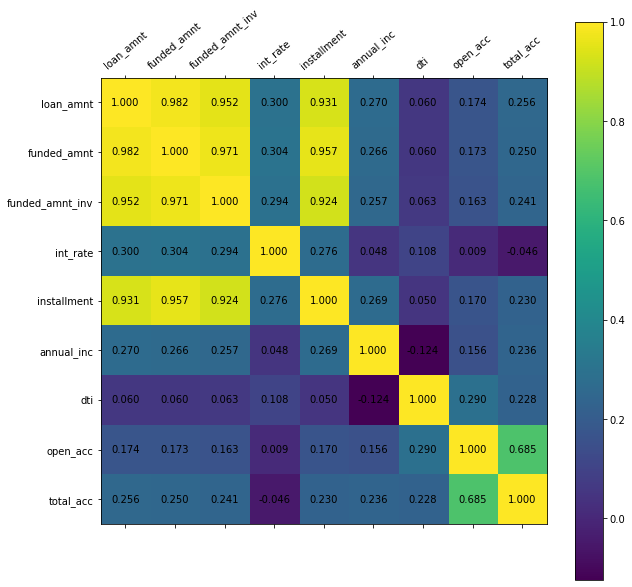

In [309]:
df = loanDfCleaned.loc[:, numericalVariables]
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=40)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
for (i, j), z in np.ndenumerate(df.corr()):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.savefig('Correlation_Matrix_numericalVariables.png')

Here we can see that some numerical columns have a strong correlation so we choose to keep only some of them. <br>
We will remove **installment**, **funded_amnt** and **funded_amnt_inv** as we have to analyse the risk on the basis of loan amount requested by user.

In [310]:
cols = ['installment', 'funded_amnt', 'funded_amnt_inv'];
loanDfCleaned.drop(columns=cols, inplace=True)
coloumnsDropped = coloumnsDropped + cols

In [311]:
loanDfCleaned.to_csv('loanCleaned.csv', index=False)

With that our final list of variables and their bifurcation looks like

In [312]:
targetVariables = ['loan_status', 'defaulted']

dateVariables = ['issue_d']

categoricalVariables = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
                        'verification_status', 'purpose', 'addr_state', 'zip_code', 
                        'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies', 
                        'application_type']

numericalVariables = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'total_acc']

In [313]:
df = copy(loanDfCleaned)

In [314]:
(df['grade'].value_counts() * 100 / len(df))

B    30.296196
A    25.864130
C    20.309783
D    13.184783
E     6.994565
F     2.551630
G     0.798913
Name: grade, dtype: float64

## Default Rates for categorical variables

In [315]:
# Get overall default rate
def getOverallDefaultRate(Df):
    return Df['defaulted'].mean()

# Get plot for default rates
def getDefaultRatePlot(Df, fields):
    bygroup = Df.groupby(by=fields)
    return bygroup['defaulted'].mean().plot.bar()

# Get impact plot for default rates. This indicates how does a categorical variable impact default rate
def getDefaultRateImpactPlot(Df, fields):
    bygroup = Df.groupby(by=fields)
    return (bygroup['defaulted'].mean() - getOverallDefaultRate(Df)).plot.bar()

In [316]:
byGrade = df.groupby(by=['grade'])

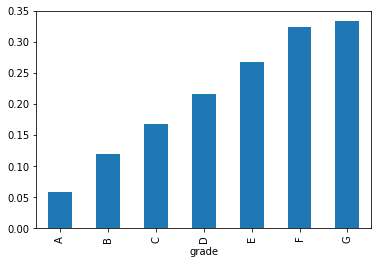

In [317]:
plot = getDefaultRatePlot(df, ['grade'])

We can see that the default rates increase as the grade goes from A to G

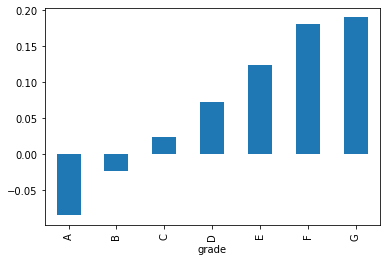

In [318]:
plot = getDefaultRateImpactPlot(df, ['grade'])

We can see that grade A loans have negative 5% (decreases chances of defaults by 5%) impact on default-rate whereas grade G loans have positive 20% impact of defaults (increases the normal chances of defaults by 20%)

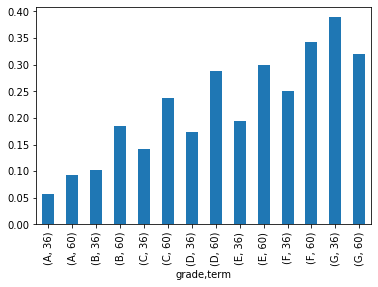

In [319]:
plot = getDefaultRatePlot(df, ['grade', 'term'])

Grade G loans with a term plan of 36 months have the highest default rate (40%)

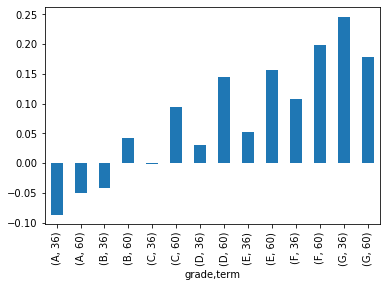

In [320]:
plot = getDefaultRateImpactPlot(df, ['grade', 'term'])

Grade G loans with a term plan of 36 months increase the chances of defaults by 25%

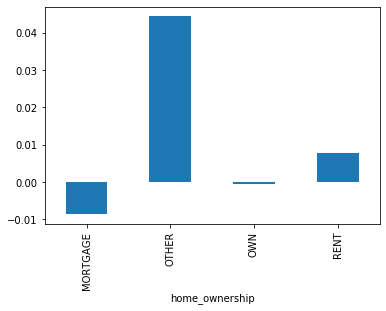

In [321]:
plot = getDefaultRateImpactPlot(df, ['home_ownership'])

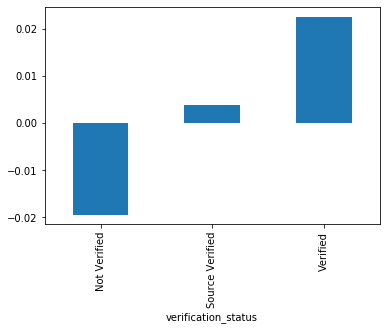

In [322]:
plot = getDefaultRateImpactPlot(df, ['verification_status'])

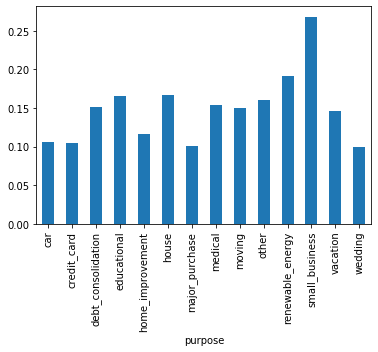

In [323]:
plot = getDefaultRatePlot(df, ['purpose'])

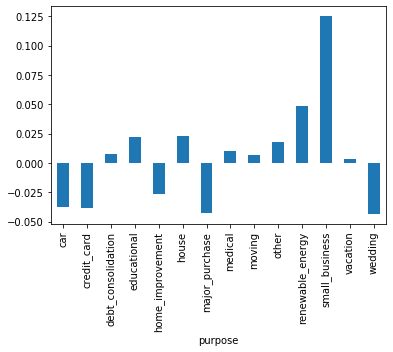

In [324]:
plot = getDefaultRateImpactPlot(df, ['purpose'])

**Small business** loans seem to increase the default rates by 12.5%

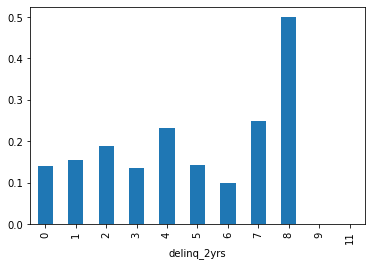

In [325]:
plot = getDefaultRatePlot(df, ['delinq_2yrs'])

In [326]:
df[df['delinq_2yrs'] == 8]

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,application_type,pub_rec_bankruptcies,defaulted
15034,4200,36,15.62,D,D1,2,RENT,35000.0,Not Verified,May-11,...,478,79.7,19,0.0,0.0,4850.259801,4850.26,INDIVIDUAL,0.0,0
19488,12000,60,18.25,F,F1,3,RENT,67200.0,Source Verified,Feb-11,...,2409,65.1,17,0.0,0.0,3375.010000,2923.54,INDIVIDUAL,1.0,1


Only two rows are present which is not enough data to conclude that 50% people defaults if they have 8 deliquencies in last 2 years

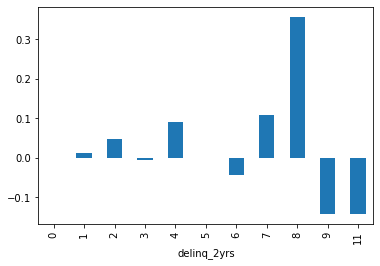

In [327]:
plot = getDefaultRateImpactPlot(df, ['delinq_2yrs'])

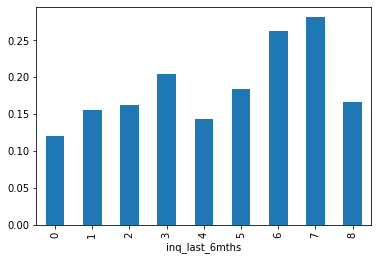

In [328]:
plot = getDefaultRatePlot(df, ['inq_last_6mths'])

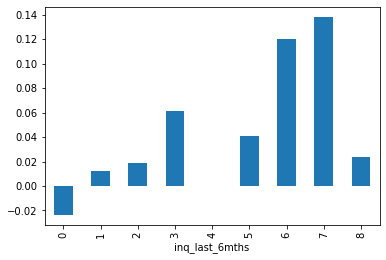

In [329]:
plot = getDefaultRateImpactPlot(df, ['inq_last_6mths'])

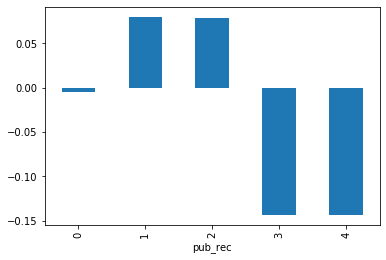

In [330]:
plot = getDefaultRateImpactPlot(df, ['pub_rec'])

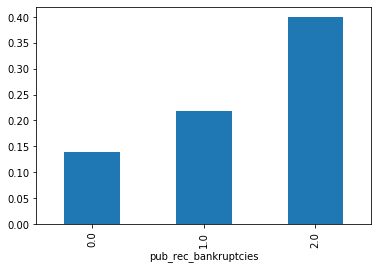

In [331]:
plot = getDefaultRatePlot(df, ['pub_rec_bankruptcies'])

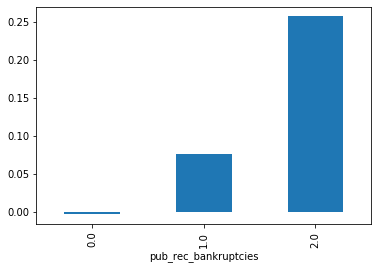

In [332]:
plot = getDefaultRateImpactPlot(df, ['pub_rec_bankruptcies'])

People having 2 or more publically bankrupcies records are 25% higher chance of default